## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [5]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

## Загружаем исходные данные

In [6]:
train = np.loadtxt("./data/digit/train.csv", delimiter=",", skiprows=1)
test = np.loadtxt("./data/digit/test.csv", delimiter=",", skiprows=1)

In [7]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [8]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

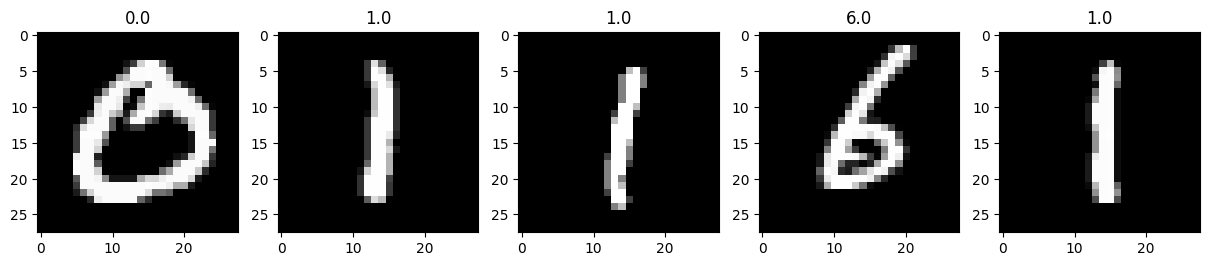

In [9]:
# Specify the number of images you want to sample
num_samples = 5

# Get the number of images in the train_img array
num_train_images = train_img.shape[0]

# Generate random indices for the sample
random_indices = random.sample(range(num_train_images), num_samples)

# Create a figure to display the images
fig = plt.figure(figsize=(15, 3))

# Enumerate the sampled images starting from 1
for i, img_index in enumerate(random_indices, 1):
    img = train_img[img_index]  # Read the i-th image
    subplot = fig.add_subplot(1, 5, i)  # 1 row, 5 cols, i-th subplot
    plt.imshow(img, cmap="gray")
    subplot.set_title("%s" % train_label[img_index])

# Show the plot
plt.show()

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [10]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)  #
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [11]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [12]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [13]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

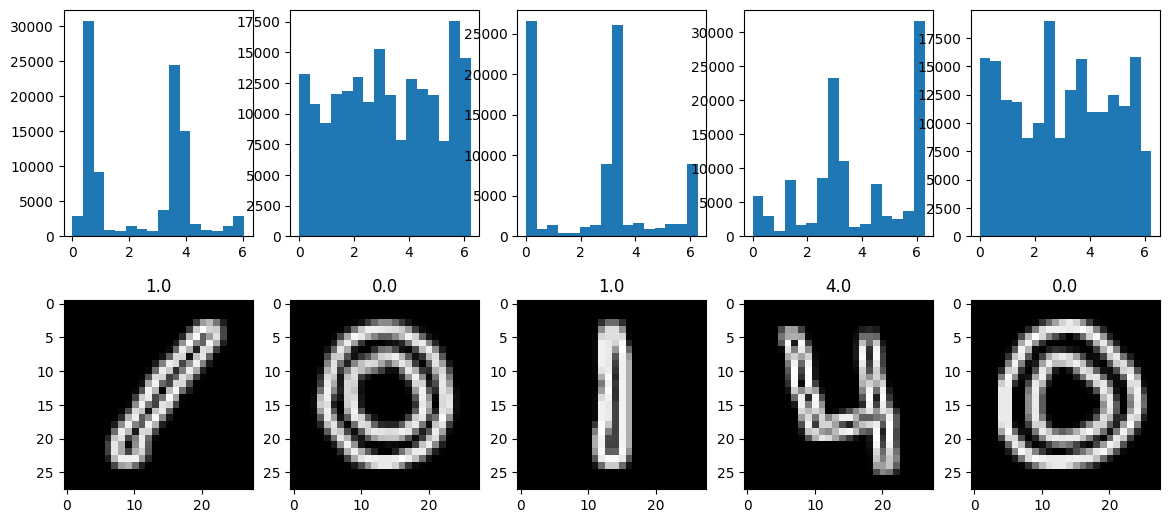

In [14]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap="gray")
    subplot.set_title("%s" % train_label[i - 1])
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(), bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [68]:
# Гистограммы вычисляются с учетом длины вектора градиента

bins = 64
train_hist = np.zeros((len(train_img), bins))
for i in range(len(train_img)):
    hist, borders = np.histogram(
        train_theta[i], bins=bins, range=(0.0, 2.0 * np.pi), weights=train_g[i]
    )
    train_hist[i] = hist

    
test_hist = np.zeros((len(test_img), bins))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=bins,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [69]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [70]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [71]:
from sklearn.model_selection import train_test_split

y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42
)

In [72]:
# !pip install xgboost

## Вычисляем центроиды каждого из 10 классов

In [73]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [74]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [75]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [76]:
from sklearn.metrics import accuracy_score

print("Accuracy: %s" % accuracy_score(y_val, pred_val))

Accuracy: 0.4419047619047619


In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.45      0.22      0.30       816
         1.0       0.59      0.72      0.65       909
         2.0       0.34      0.28      0.30       846
         3.0       0.57      0.51      0.54       937
         4.0       0.35      0.32      0.33       839
         5.0       0.46      0.68      0.55       702
         6.0       0.25      0.44      0.32       785
         7.0       0.64      0.48      0.55       893
         8.0       0.40      0.50      0.45       835
         9.0       0.50      0.28      0.36       838

    accuracy                           0.44      8400
   macro avg       0.45      0.44      0.43      8400
weighted avg       0.46      0.44      0.44      8400



In [78]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_val, pred_val))

[[183  32  87  27  78  20 188   7 157  37]
 [  0 656   2   0  82   1 112  47   8   1]
 [ 30   1 234 145  12 211  53  24 121  15]
 [ 13   0 105 478   3 214   5   3 103  13]
 [ 23 224  10   2 270   1 190  67  26  26]
 [  5   2  81  93   1 476   4   4  34   2]
 [ 53  28  66   7 117   6 343  21  84  60]
 [  4  93  32   9  55  46 173 425  17  39]
 [ 79   5  58  55  32  39 108   5 415  39]
 [ 20  80  22  25 132  10 193  63  61 232]]


## Предсказания на тестовых данных

In [79]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

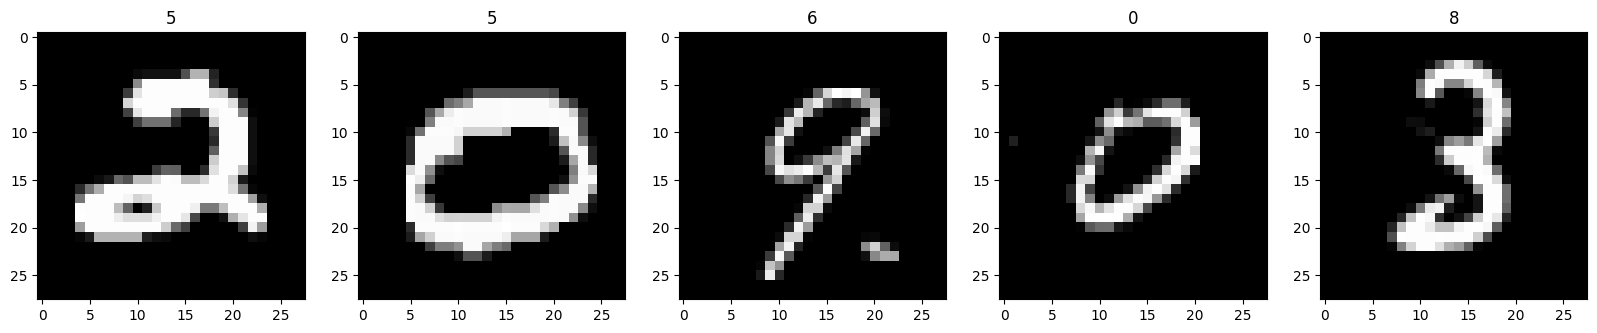

In [80]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap="gray")
    subplot.set_title("%s" % pred_test[i - 1])

# Let's try another approach

Let's consider histogram of oriented gradients (HOG) as a feature for classification.  
We will use xgboost library to train a classifier.


In [91]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(test_hist)

param = {"max_depth": 7, "eta": 0.1, "objective": "multi:softmax", "num_class": 10}

num_round = 1000
bst = xgb.train(param, dtrain, num_round)

pred_val = bst.predict(dval)
print(accuracy_score(y_val, pred_val))

pred_test = bst.predict(dtest)

0.7015476190476191


In [92]:
# from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_val, pred_val))

[[491   4  58  21  14  21  66   6 122  13]
 [  1 875   1   0  16   0   2   4   2   8]
 [ 49   0 418 115  10  97  50  16  70  21]
 [ 13   0  98 668   0  72   7   5  57  17]
 [ 27   4   8   0 629   1  74  21   8  67]
 [ 10   0  64  98   2 487   7   7  25   2]
 [102   2  46  14  43  12 440   6  75  45]
 [  2   4  21   2  28  14  26 733   6  57]
 [100   1  28  53   3  36  57   4 528  25]
 [ 36   3  22  13  50   6  42  19  23 624]]


## Визуализируем предсказания

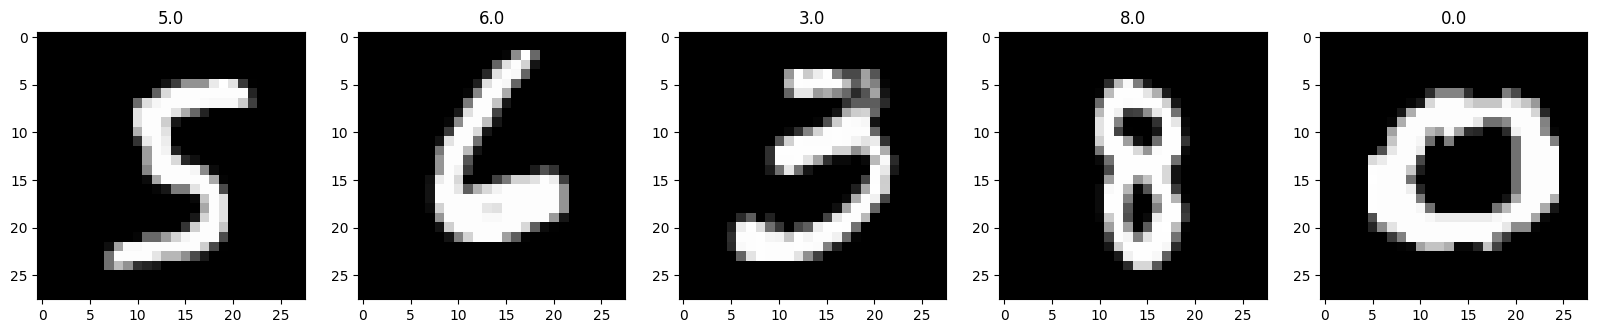

In [93]:
# Specify the number of images you want to sample
num_samples = 5

# Get the number of images in the train_img array
num_pred_images = pred_test.shape[0]

# Generate random indices for the sample
random_indices = random.sample(range(num_pred_images), num_samples)

fig = plt.figure(figsize=(20, 10))
for i, img_index in enumerate(random_indices, 1):
    img = test_img[img_index]  # Read the i-th test image
    subplot = fig.add_subplot(1, 5, i)  # 1 row, 5 cols, i-th subplot
    plt.imshow(img, cmap="gray")
    subplot.set_title("%s" % pred_test[img_index])

## Готовим файл для отправки (csv)

In [94]:
# with open("submit.txt", "w") as dst:
#     dst.write("ImageId,Label\n")
#     for i, p in enumerate(pred_test, 1):
#         dst.write("%s,%s\n" % (i, p))

In [95]:
import pandas as pd

# make df with two columns of integers
df = pd.DataFrame({'ImageId': range(1, len(pred_test) + 1), 'Label': pred_test.astype(int)})
# set index to ImageId column
df.set_index('ImageId', inplace=True)
# save to csv
df.to_csv("submit.csv", header=True)



In [96]:
df.head()

,Label
ImageId,
1,5
2,3
3,9
4,2
5,3


In [97]:
# !head submit.txt

In [98]:
# Your submission Score: 0.70207

![Screenshot 2023-10-22 at 22.39.43.png](<attachment:Screenshot 2023-10-22 at 22.39.43.png>)
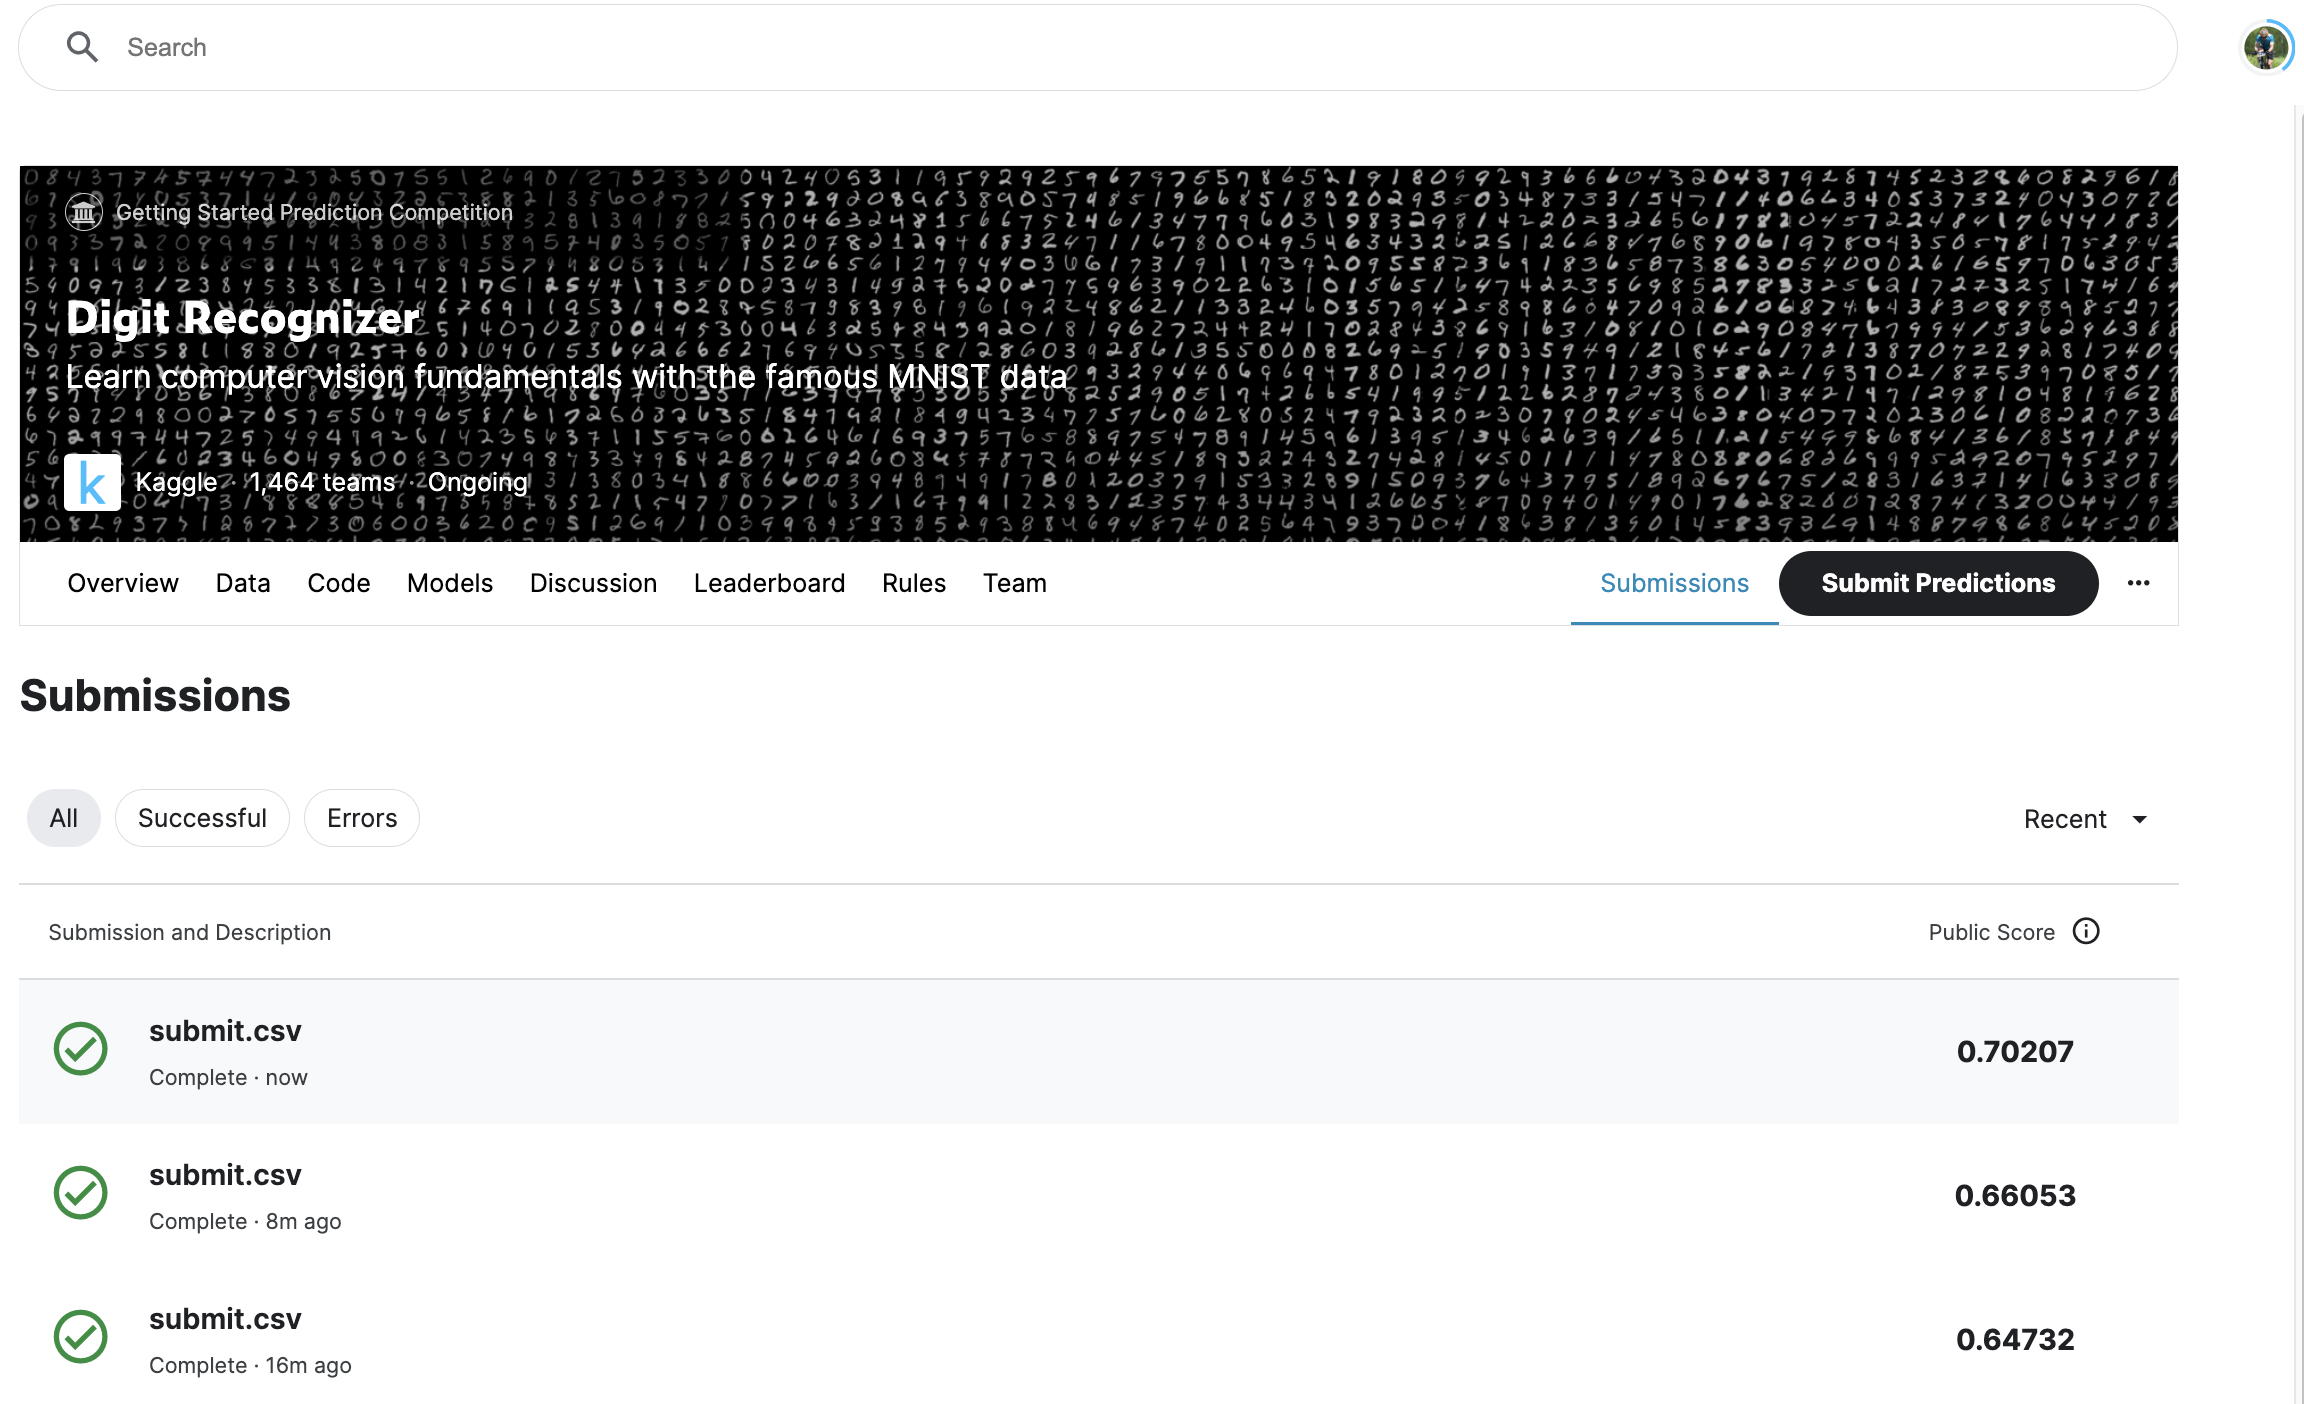